# Data Pre-processing

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import random
from shapely.geometry import Point

In [3]:
data = pd.read_csv("clustering_data.csv")

<ipython-input-3-35632261e7c2>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("clustering_data.csv")


In [4]:
data.shape

(157126, 11)

In [5]:
data.columns

Index(['CircleName', 'RegionName', 'DivisionName', 'OfficeName', 'Pincode',
       'OfficeType', 'Delivery', 'District', 'StateName', 'Latitude',
       'Longitude'],
      dtype='object')

In [6]:
data.head()

,CircleName,RegionName,DivisionName,OfficeName,Pincode,OfficeType,Delivery,District,StateName,Latitude,Longitude
0,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Peddakotla B.O,515631,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.5689,77.85624
1,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Pinnadhari B.O,515631,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.5281,77.857014
2,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Yerraguntapalle B.O,515631,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.561111,77.85715
3,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Obulareddipalli B.O,515581,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.2488,78.2588
4,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Odulapalli B.O,515581,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.24555,78.2477


In [7]:
data= data[data['StateName']=='MAHARASHTRA']

In [8]:
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')

In [11]:
# drop NaN values, drop duplicates, handle any outliers(the ones that lie outside the extent of India)
data = data.dropna(subset=['Latitude', 'Longitude'])
data = data.drop_duplicates()
data = data[
    (data['Latitude'] >= 8.0667) & (data['Latitude'] <= 37.1) &
    (data['Longitude'] >= 68.1167) & (data['Longitude'] <= 97.4167)
]

In [12]:
data.shape

(11613, 11)

In [15]:
# Step 1: Load your data as a GeoDataFrame
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
data = data.dropna(subset=['Longitude', 'Latitude'])

geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
points_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# Step 2: Load the shapefile or GeoJSON of Indian states
india_states = gpd.read_file("geoBoundaries-IND-ADM1.geojson")

# Step 3: Spatial join to find which state each point belongs to
points_with_state = gpd.sjoin(points_gdf, india_states, how="inner", predicate="within")

# Step 4: Filter for a particular state, e.g., Maharashtra
state_points = points_with_state[points_with_state['shapeName'] == 'Mahārāshtra']

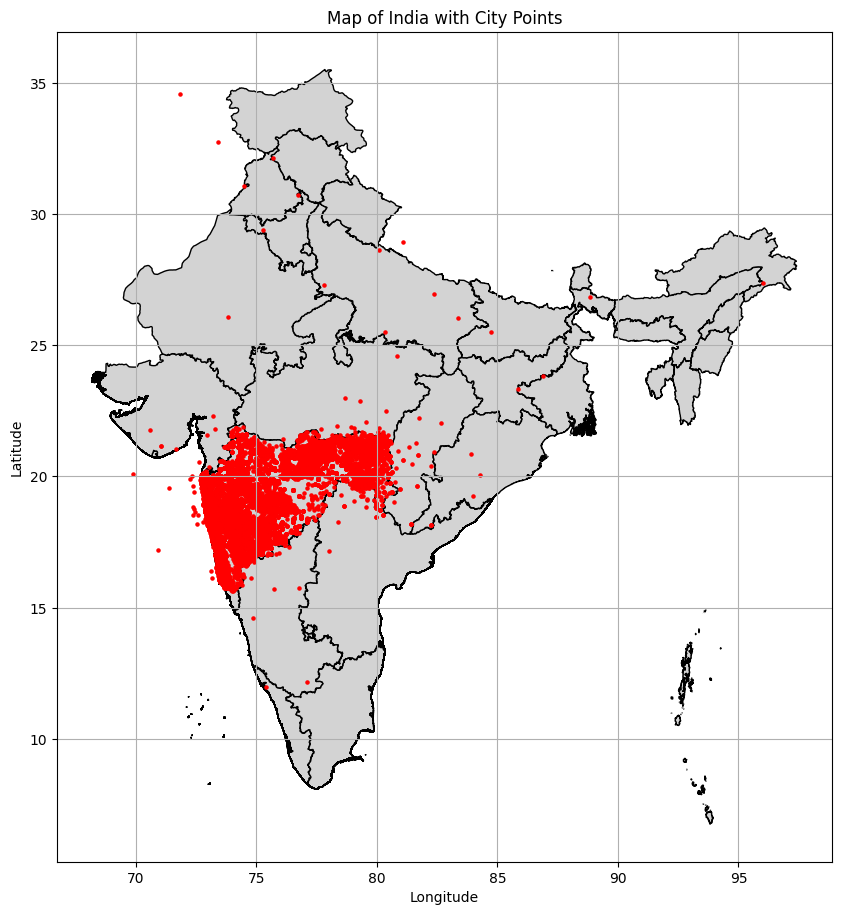

In [16]:
# For the state boundaries

# Load India states GeoJSON
gdf = gpd.read_file("india_state.geojson")

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
points_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(ax=ax, color='lightgray', edgecolor='black')
points_gdf.plot(ax=ax, color='red', markersize=5)

plt.title("Map of India with City Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

['Puducherry' 'Mahārāshtra' 'Nāgāland' 'Lakshadweep' 'Uttar Pradesh'
 'Tamil Nādu' 'Chhattīsgarh' 'Gujarāt' 'Delhi' 'Sikkim' 'Tripura'
 'West Bengal' 'Odisha' 'Bihār' 'Ladākh' 'Rājasthān' 'Telangāna'
 'Andhra Pradesh' 'Mizoram' 'Arunāchal Pradesh' 'Meghālaya' 'Jhārkhand'
 'Assam' 'Manipur' 'Karnātaka' 'Uttarākhand'
 'Dādra and Nagar Haveli and Damān and Diu' 'Madhya Pradesh' 'Goa'
 'Kerala' 'Chandīgarh' 'Andaman and Nicobar Islands' 'Himāchal Pradesh'
 'Jammu and Kashmīr' 'Punjab' 'Haryāna']


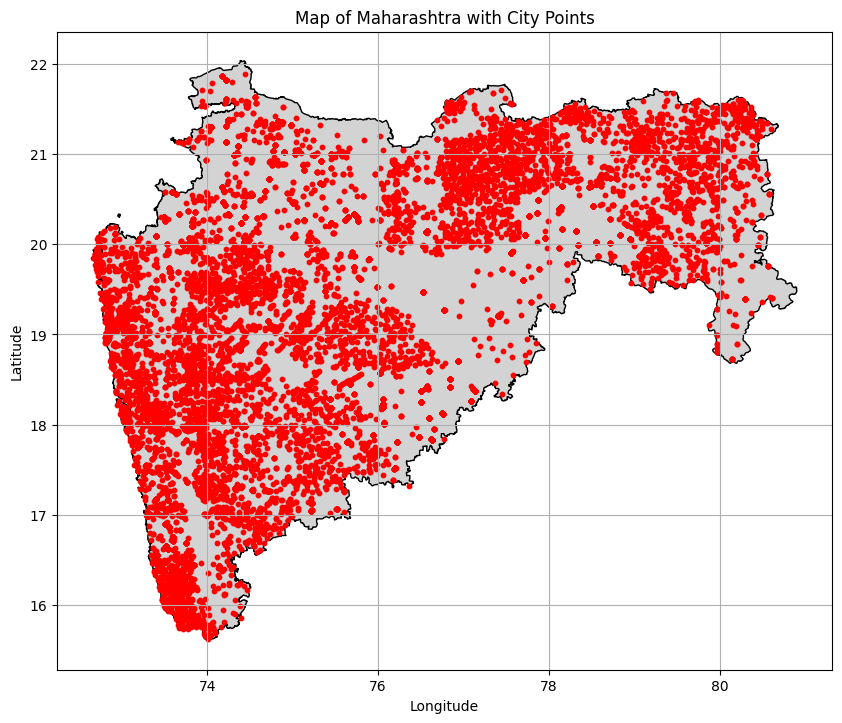

In [17]:
# Load India state boundaries
gdf = gpd.read_file("geoBoundaries-IND-ADM1.geojson")  # your state-level GeoJSON
print(gdf['shapeName'].unique())
# Filter to just the state of interest (Maharashtra)
state_gdf = gdf[gdf['shapeName'] == 'Mahārāshtra']
# state_gdf = gdf[gdf['shapeName'].str.strip().str.lower() == 'maharashtra']

# Convert DataFrame to GeoDataFrame (already filtered)
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
points_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# spatial join to ensure points are in the state
points_gdf = gpd.sjoin(points_gdf, state_gdf, how='inner', predicate='within')

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
state_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
points_gdf.plot(ax=ax, color='red', markersize=10)

plt.title("Map of Maharashtra with City Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Implementing K-Means Clustering

In [18]:
def euclidean_distance(X1,X2):
  """Returns the square of euclidean distance between two n dimensional points"""
  return (sum([(X1[i]-X2[i])**2 for i in range(len(X1))]))

In [19]:
def initialize_centroids_kmeanspp(X, k):
  """ Initialize centroids using the K-Means++ algorithm.
      The first centroid is chosen randomly, and each subsequent centroid
      is chosen with a probability proportional to its squared distance
      from the nearest existing centroid."""

  X = np.array(X)
  centroids = []
  centroids.append(X[random.randint(0, len(X)-1)])

  for _ in range(1, k):
      distances = np.array([min([euclidean_distance(x, c) for c in centroids]) for x in X])
      probabilities = distances / distances.sum()
      next_index = np.random.choice(len(X), p=probabilities)
      centroids.append(X[next_index])

  return centroids

In [20]:
def assign_clusters(X, centroids):
  """Assign each data point to the nearest centroid"""
  labels = []
  for point in X:
    distances = [euclidean_distance(point, centroid) for centroid in centroids]
    closest_centroid_index = distances.index(min(distances))
    labels.append(closest_centroid_index)
  return np.array(labels)

In [21]:
def update_centroids(X, labels, k):
  """Recalculate and assign centroids"""
  new_centroids = np.zeros((k,X.shape[1]))
  for i in range(k):
    cluster_points = X[labels == i]
    new_centroids[i] = cluster_points.mean(axis=0)
  return new_centroids

In [22]:
def has_converged(old_centroids,new_centroids, sensitivity=10**-4):
  """Check if the centroids have converged"""
  distances = [euclidean_distance(new_centroids[i],old_centroids[i]) for i in range(len(old_centroids)) ]
  return all(dist < sensitivity for dist in distances)

In [38]:
def kmeans(X, k, max_iters=100, sensitivity=1e-4):
    X = np.array(X)
    centroids = initialize_centroids_kmeanspp(X, k)

    for iteration in range(max_iters):
        labels = [np.argmin([euclidean_distance(x, c) for c in centroids]) for x in X]
        labels = np.array(labels)

        new_centroids = np.zeros((k, X.shape[1]))
        for i in range(k):
            points_in_cluster = X[labels == i]
            if len(points_in_cluster) > 0:
                new_centroids[i] = points_in_cluster.mean(axis=0)

        distances = [euclidean_distance(new_centroids[i], centroids[i]) for i in range(k)]
        if all(d <= sensitivity**2 for d in distances):  # compare squared sensitivity
            print(f"converged in {iteration} iterations.")
            break

        centroids = new_centroids

    # Compute total inertia (sum of squared distances)
    inertia = sum(euclidean_distance(X[i], centroids[labels[i]]) for i in range(len(X)))
    return centroids, labels.tolist(), inertia

Determining best K using elbow method.
Although not a very strict elbow, 6 seems to be the best k



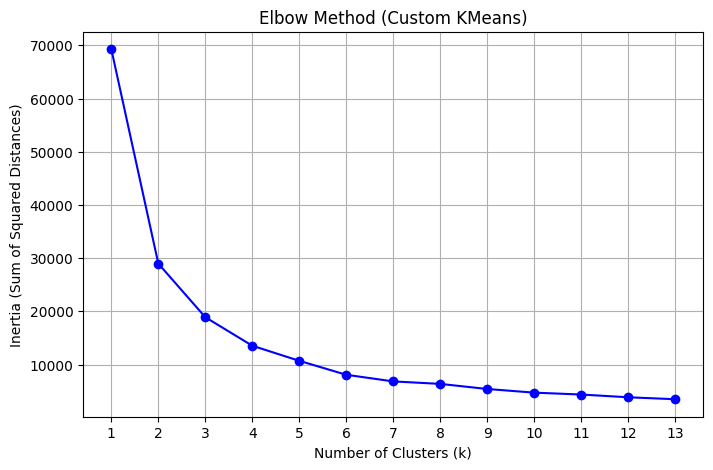

In [28]:
coords = np.array([[point.x, point.y] for point in points_gdf.geometry])

inertias = []
K = range(1, 14)

for k in K:
    centroids, labels, inertia = kmeans(coords, k)
    inertias.append(inertia)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method (Custom KMeans)')
plt.xticks(K)
plt.grid(True)
plt.show()

In [37]:
# Load GeoDataFrame
gdf = points_gdf

# Extract coordinates
X = np.array(gdf.geometry.apply(lambda geom: [geom.x, geom.y]).to_list())

# Run K-Means
centroids, labels, inertia = kmeans(X, k=6)

# Add cluster labels to GeoDataFrame
gdf["cluster"] = labels

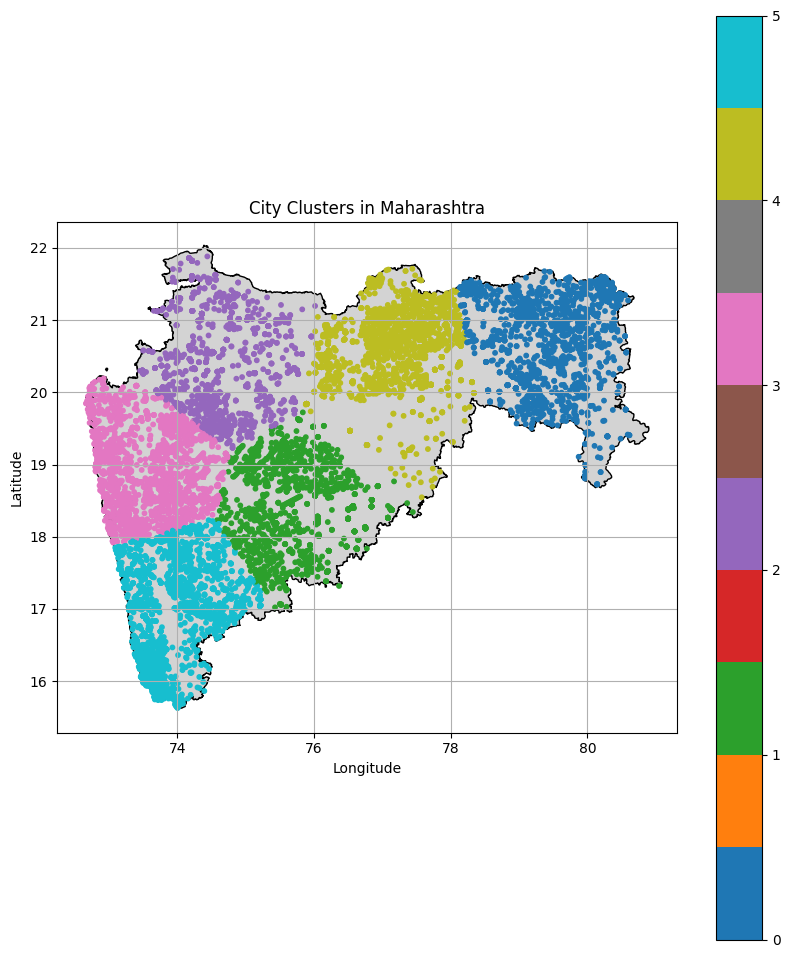

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(10, 12))

# Plot state boundaries
state_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot clustered points with color by cluster
points_gdf.plot(ax=ax, column='cluster', cmap='tab10', markersize=10, legend=True)

plt.title("City Clusters in Maharashtra")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Insights

The pincode distribution reveals that two clusters contain significantly fewer pincodes, while the remaining four have relatively balanced counts. The clusters with fewer pincodes correspond to the Marathwada region, which is known to be drought-prone and less densely populated.

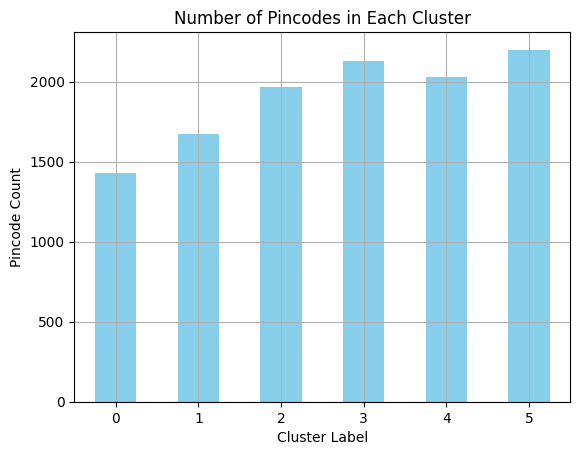

In [35]:
points_gdf = points_gdf.drop_duplicates()
counts = points_gdf.groupby('cluster').size()

counts.plot(kind='bar', color='skyblue')
plt.title("Number of Pincodes in Each Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Pincode Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In the more populated regions (i.e., denser clusters), the centroids tend to align with major cities within those areas — such as Pune, Nagpur, Satara, and Latur

In [40]:
centroid_points = [Point(xy) for xy in centroids]
centroid_gdf = None
centroid_gdf = gpd.GeoDataFrame(geometry=centroid_points, crs="EPSG:4326")

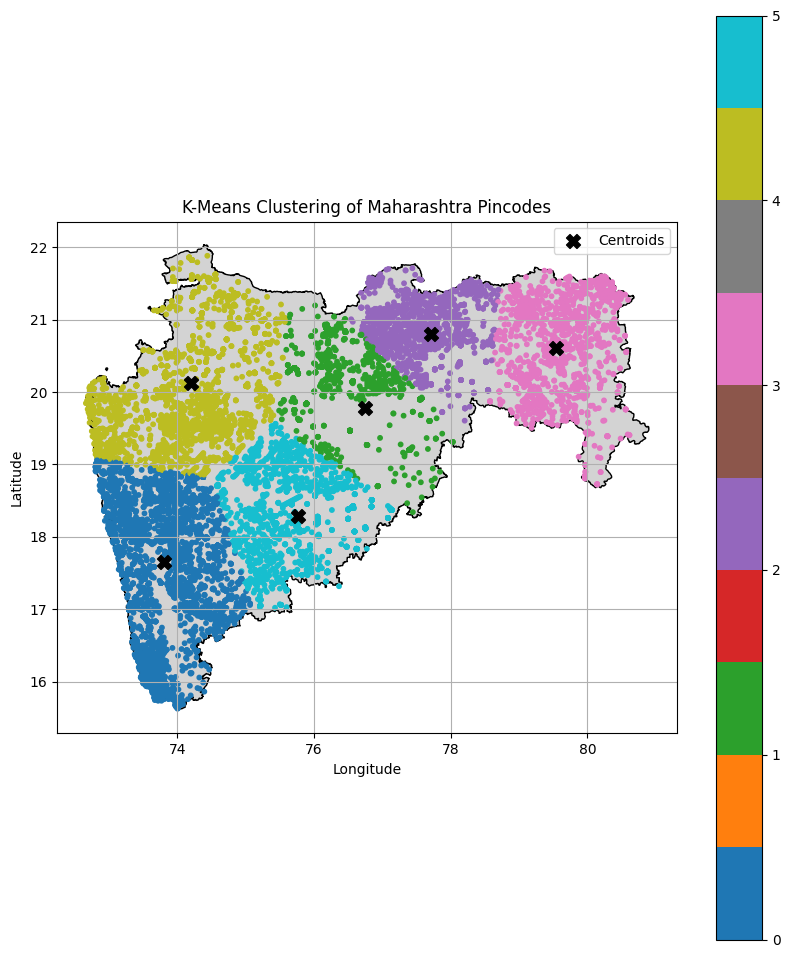

In [41]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot state boundaries
state_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot clustered points
points_gdf.plot(ax=ax, column="cluster", cmap="tab10", markersize=10, legend=True)

# Plot centroids
centroid_gdf.plot(ax=ax, color='black', marker='X', markersize=100, label='Centroids')

plt.title("K-Means Clustering of Maharashtra Pincodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.show()

**Comparing with elevation data:**
As you can see the below, elevation affects the distribution of pincodes(and hence population!). The western ghats form a vertical strip of almost no pincodes. Similarly the deccan plateau has a similar effect in the southeastern part.

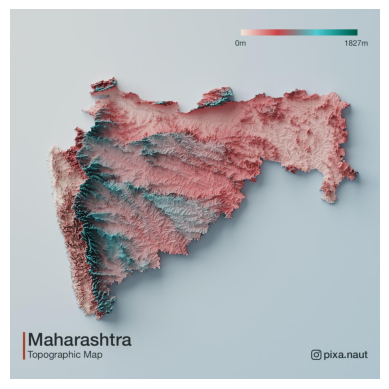

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image from the URL
img = mpimg.imread('elevation_map.jpg')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()
